In [245]:
import numpy as np
import pandas as pd

# Checkpoint 1: Data Cleaning

In [246]:
#1. Load the companies and rounds data into two data frames and name them companies and rounds2 respectively.

In [247]:
#Load companies.csv file data into dataframe
companies = pd.read_csv('companies.csv', encoding = 'ISO-8859-1')

In [248]:
# Removing the special characters
companies['permalink']=companies[['permalink']].applymap(lambda x: x.encode('ISO-8859-1').decode('ascii', 'ignore'))
companies['name']=companies.name.str.encode('ISO-8859-1').str.decode('ascii', 'ignore')

In [249]:
#check if nulls in companies DF
companies.isnull().sum()

permalink            0
name                 1
homepage_url      5058
category_list     3148
status               0
country_code      6958
state_code        8547
region            8030
city              8028
founded_at       15221
dtype: int64

In [250]:
#Load rounds2.csv file data into dataframe
rounds2 = pd.read_csv('rounds2.csv',encoding='ISO-8859-1')

In [251]:
# Removing the special characters
rounds2['company_permalink']=rounds2[['company_permalink']].applymap(lambda x: x.encode('ISO-8859-1').decode('ascii', 'ignore'))
rounds2['funding_round_permalink']=rounds2[['funding_round_permalink']].applymap(lambda x: x.encode('ISO-8859-1').decode('ascii', 'ignore'))

In [252]:
#check if nulls in rounds2 DF
rounds2.isnull().sum()

company_permalink              0
funding_round_permalink        0
funding_round_type             0
funding_round_code         83809
funded_at                      0
raised_amount_usd          19990
dtype: int64

**1. How many unique companies are present in rounds2?**

In [253]:
rounds2.company_permalink = rounds2.company_permalink.apply(lambda x: x.upper())
len(rounds2.company_permalink.unique())

66368

**2. How many unique companies are present in companies?**

In [254]:
companies.permalink = companies.permalink.apply(lambda x: x.upper())
len(companies.permalink.unique())

66368

**3. In the companies data frame, which column can be used as the unique key for each company? Write the name of the column.**

Answer: *permalink*

**4. Are there any companies in the rounds2 file which are not present in companies? Yes or No**

In [255]:
len(rounds2[~rounds2['company_permalink'].isin(companies['permalink'])])

0

Answer: No

**5.a. Merge the two data frames so that all variables (columns) in the companies frame are added to the rounds2 data frame. 
Name the merged frame master_frame.**

In [256]:
#Creation of master dataframe
master_frame = pd.merge(rounds2,companies,how='inner',left_on='company_permalink',right_on='permalink')

**5.b. How many observations are present in master_frame ?**

In [257]:
#no.of rows and columns in master data frame
master_frame.shape

(114949, 16)

**5.c. Data cleaning on master dataframe**

In [258]:
#check no.of nulls or missing data in master data frame
master_frame.isnull().sum()

company_permalink              0
funding_round_permalink        0
funding_round_type             0
funding_round_code         83809
funded_at                      0
raised_amount_usd          19990
permalink                      0
name                           1
homepage_url                6134
category_list               3410
status                         0
country_code                8678
state_code                 10946
region                     10167
city                       10164
founded_at                 20521
dtype: int64

In [259]:
#The result has a redundant column that we can drop
master_frame = master_frame.drop('permalink', axis=1)

In [260]:
#no.of rows and columns in master data frame
master_frame.shape

(114949, 15)

In [261]:
# Find missing data or nulls in terms of percentage for data cleaning
round(100*(master_frame.isnull().sum()/len(master_frame.index)), 2)

company_permalink          0.00
funding_round_permalink    0.00
funding_round_type         0.00
funding_round_code        72.91
funded_at                  0.00
raised_amount_usd         17.39
name                       0.00
homepage_url               5.34
category_list              2.97
status                     0.00
country_code               7.55
state_code                 9.52
region                     8.84
city                       8.84
founded_at                17.85
dtype: float64

In [262]:
# Dropping missing data from the column 'raised_amount_usd' which is needed for further analysis
master_frame.drop(master_frame[master_frame['raised_amount_usd'].isnull()].index, inplace = True)

In [263]:
# Dropping values with 0 investment. (i.e) raised_amount_usd is 0
master_frame.drop(master_frame[master_frame['raised_amount_usd'] == 0.00].index, inplace = True)

In [264]:
# Find missing data or nulls in terms of percentage for data cleaning
round(100*(master_frame.isnull().sum()/len(master_frame.index)), 2)

company_permalink          0.00
funding_round_permalink    0.00
funding_round_type         0.00
funding_round_code        70.22
funded_at                  0.00
raised_amount_usd          0.00
name                       0.00
homepage_url               4.51
category_list              1.08
status                     0.00
country_code               6.15
state_code                 8.00
region                     7.41
city                       7.41
founded_at                16.87
dtype: float64

In [265]:
# Remove where status is 'closed' as there is no investment going to happen for these companies.
master_frame = master_frame[master_frame['status']!='closed']

In [266]:
master_frame = master_frame.drop('funding_round_code', axis=1)
master_frame = master_frame.drop('founded_at', axis=1)
master_frame = master_frame.drop('homepage_url', axis=1)
master_frame = master_frame[pd.notnull(master_frame['country_code'])]
master_frame = master_frame[pd.notnull(master_frame['state_code'])]
master_frame = master_frame[pd.notnull(master_frame['city'])]
master_frame = master_frame[pd.notnull(master_frame['region'])]
master_frame = master_frame[pd.notnull(master_frame['category_list'])]

In [267]:
# Find missing data or nulls in terms of percentage for data cleaning
round(100*(master_frame.isnull().sum()/len(master_frame.index)), 2)

company_permalink         0.00
funding_round_permalink   0.00
funding_round_type        0.00
funded_at                 0.00
raised_amount_usd         0.00
name                      0.00
category_list             0.00
status                    0.00
country_code              0.00
state_code                0.00
region                    0.00
city                      0.00
dtype: float64

In [268]:
master_frame.shape

(80561, 12)

# Checkpoint 2: Funding Type Analysis

In [269]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

**1. Calculate the most representative value of the investment amount for each of the four funding types (venture, angel, seed, and private equity)**

In [270]:
funding_types_frame=pd.DataFrame(master_frame.loc[(master_frame['funding_round_type'] == 'venture') | 
                                                  (master_frame['funding_round_type'] == 'angel') | 
                                                  (master_frame['funding_round_type'] == 'seed') | 
                                                  (master_frame['funding_round_type'] == 'private_equity'), :].
                                groupby('funding_round_type')['raised_amount_usd'].mean().sort_values(ascending = False))
funding_types_frame.reset_index(inplace=True)
funding_types_frame.head()

,funding_round_type,raised_amount_usd
0,private_equity,72781085.15
1,venture,11923366.36
2,angel,1009538.34
3,seed,759381.64


**2. Based on the most representative investment amount calculated above, which investment type do you think is the most suitable for Spark Funds? Considering that Spark Funds wants to invest between 5 to 15 million USD per investment round, which investment type is the most suitable for it? Identify the investment type and, for further analysis, filter the data so it only contains the chosen investment type.**


In [271]:
funding_types_frame.loc[(funding_types_frame['raised_amount_usd'] > 5000000.00) &
                        (funding_types_frame['raised_amount_usd'] < 15000000.00)]

,funding_round_type,raised_amount_usd
1,venture,11923366.36


Answer: *So, **venture** type is best option*

# Checkpoint 3: Country Analysis

**1. Spark Funds wants to see the top nine countries which have received the highest total funding (across ALL sectors for the chosen investment type)**

In [272]:
v_df = master_frame[master_frame["funding_round_type"]=="venture"]
v_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43866 entries, 0 to 114941
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   company_permalink        43866 non-null  object 
 1   funding_round_permalink  43866 non-null  object 
 2   funding_round_type       43866 non-null  object 
 3   funded_at                43866 non-null  object 
 4   raised_amount_usd        43866 non-null  float64
 5   name                     43866 non-null  object 
 6   category_list            43866 non-null  object 
 7   status                   43866 non-null  object 
 8   country_code             43866 non-null  object 
 9   state_code               43866 non-null  object 
 10  region                   43866 non-null  object 
 11  city                     43866 non-null  object 
dtypes: float64(1), object(11)
memory usage: 4.4+ MB


In [273]:
# Data frame created with top 9 countries
v_df2 = pd.DataFrame(v_df.groupby('country_code').
             raised_amount_usd.sum()).sort_values(by = 'raised_amount_usd', ascending = False)[:9]
v_df2.head(10)

,raised_amount_usd
country_code,
USA,398087049988.00
CHN,36294228421.00
GBR,17370195887.00
IND,13879053718.00
CAN,8700436768.00
FRA,6364231789.00
ISR,6194267458.00
DEU,5894963052.00
JPN,3006705579.00


**2. For the chosen investment type, make a data frame named top9 with the top nine countries (based on the total investment amount each country has received)**

In [274]:
#Filtering the data with these top 9 countries only.
top9 = v_df[v_df['country_code'].isin(["USA","CHN","GBR","IND","CAN","FRA","ISR","DEU","JPN"])]

In [275]:
# From the above list, Top 3 English speaking countries
top3_english = top9[top9["country_code"].isin(['USA', 'GBR', 'IND'])]
top3_english.groupby('country_code')['raised_amount_usd'].sum().sort_values(ascending=False)

country_code
USA   398087049988.00
GBR    17370195887.00
IND    13879053718.00
Name: raised_amount_usd, dtype: float64

1. Top English speaking country = **USA**
2. Second English speaking country = **GBR**
3. Third English speaking country = **IND** 

# Checkpoint 4: Sector Analysis 1 

In [276]:
mapping=pd.read_csv('mapping.csv')
mapping.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 688 entries, 0 to 687
Data columns (total 10 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   category_list                            687 non-null    object
 1   Automotive & Sports                      688 non-null    int64 
 2   Blanks                                   688 non-null    int64 
 3   Cleantech / Semiconductors               688 non-null    int64 
 4   Entertainment                            688 non-null    int64 
 5   Health                                   688 non-null    int64 
 6   Manufacturing                            688 non-null    int64 
 7   News, Search and Messaging               688 non-null    int64 
 8   Others                                   688 non-null    int64 
 9   Social, Finance, Analytics, Advertising  688 non-null    int64 
dtypes: int64(9), object(1)
memory usage: 53.9+ KB


In [277]:
mapping.shape

(688, 10)

In [278]:
# Data cleaning
mapping=mapping[~mapping.category_list.isnull()]
mapping=mapping[~mapping.category_list.isna()]

mapping.shape

(687, 10)

In [279]:
mapping.Blanks.count()

687

In [280]:
def categoryMap(category):
    if '0' in category:
        if category.startswith("0"):
            return category[:category.find('0')]+'Na'+category[category.find('0')+1:]
        elif category.endswith("0"):
            return category
        else:
            return category[:category.find('0')]+'na'+category[category.find('0')+1:]
    else:
        return category

In [281]:
mapping['category_list']=list(map(categoryMap,mapping['category_list']))

In [282]:
top9['primary_sector'] =top9['category_list'].astype(str).apply(lambda x: x.split('|')[0])

C:\Backup\Masters\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [283]:
top9.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40912 entries, 0 to 114941
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   company_permalink        40912 non-null  object 
 1   funding_round_permalink  40912 non-null  object 
 2   funding_round_type       40912 non-null  object 
 3   funded_at                40912 non-null  object 
 4   raised_amount_usd        40912 non-null  float64
 5   name                     40912 non-null  object 
 6   category_list            40912 non-null  object 
 7   status                   40912 non-null  object 
 8   country_code             40912 non-null  object 
 9   state_code               40912 non-null  object 
 10  region                   40912 non-null  object 
 11  city                     40912 non-null  object 
 12  primary_sector           40912 non-null  object 
dtypes: float64(1), object(12)
memory usage: 4.4+ MB


In [284]:
#data massage
massage_df=pd.melt(mapping, id_vars=['category_list'], var_name=['main_sector'])
massage_df=massage_df[massage_df.value==1]
massage_df=massage_df.drop('value',axis=1)
massage_df.info()

top9.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 687 entries, 7 to 6158
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   category_list  687 non-null    object
 1   main_sector    687 non-null    object
dtypes: object(2)
memory usage: 16.1+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 40912 entries, 0 to 114941
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   company_permalink        40912 non-null  object 
 1   funding_round_permalink  40912 non-null  object 
 2   funding_round_type       40912 non-null  object 
 3   funded_at                40912 non-null  object 
 4   raised_amount_usd        40912 non-null  float64
 5   name                     40912 non-null  object 
 6   category_list            40912 non-null  object 
 7   status                   40912 non-null  object 
 8   country_code             40

In [285]:
top9=pd.merge(top9,massage_df,how="left",left_on="primary_sector",right_on="category_list")
top9.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40912 entries, 0 to 40911
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   company_permalink        40912 non-null  object 
 1   funding_round_permalink  40912 non-null  object 
 2   funding_round_type       40912 non-null  object 
 3   funded_at                40912 non-null  object 
 4   raised_amount_usd        40912 non-null  float64
 5   name                     40912 non-null  object 
 6   category_list_x          40912 non-null  object 
 7   status                   40912 non-null  object 
 8   country_code             40912 non-null  object 
 9   state_code               40912 non-null  object 
 10  region                   40912 non-null  object 
 11  city                     40912 non-null  object 
 12  primary_sector           40912 non-null  object 
 13  category_list_y          40904 non-null  object 
 14  main_sector           

In [286]:
top9=top9.drop('category_list_y',axis=1)

In [287]:
len(top9[top9['main_sector'].isnull()])

8

In [288]:
top9=top9[~(top9['main_sector'].isnull())]

# Checkpoint 5: Sector Analysis 2

**1. Create three separate data frames D1, D2 and D3 for each of the three countries containing the observations of funding type FT falling within the 5-15 million USD range.**

In [289]:
top9 = top9[pd.notnull(top9['primary_sector'])]
top9 = top9[pd.notnull(top9['main_sector'])]

D1=top9[top9['country_code']=='USA']
D1 = D1[(D1['raised_amount_usd'] >= 5000000) & (D1['raised_amount_usd'] <= 15000000)]

D2=top9[top9['country_code']=='GBR']
D2 = D2[(D2['raised_amount_usd'] >= 5000000) & (D2['raised_amount_usd'] <= 15000000)]

D3=top9[top9['country_code']=='IND']
D3 = D3[(D3['raised_amount_usd'] >= 5000000) & (D3['raised_amount_usd'] <= 15000000)]

 1. Total amount of investments (sum) - **USA**

In [290]:
D1.raised_amount_usd.sum()

100934166779.0

 1. Total amount of investments (sum) - **GBR**

In [291]:
D2.raised_amount_usd.sum()

4859391463.0

 1. Total amount of investments (sum) - **IND**

In [292]:
D3.raised_amount_usd.sum()

2805673602.0

 2. Total number of investments (count) - **USA**

In [293]:
D1.raised_amount_usd.count()

11279

 2. Total number of investments (count) - **GBR**

In [294]:
D2.raised_amount_usd.count()

556

 2. Total number of investments (count) - **IND**

In [295]:
D3.raised_amount_usd.count()

314

In [296]:
#The total count invested in each main sector in a separate column

D1_sector=D1.groupby('main_sector')
D1_sector['raised_amount_usd'].count().sort_values(ascending = False).head()

#The total amount invested in each main sector in a separate column
D1_sector['raised_amount_usd'].sum().sort_values(ascending = False).head()

main_sector
Others                                    24624698580.00
Social, Finance, Analytics, Advertising   22810769582.00
Cleantech / Semiconductors                20110326351.00
News, Search and Messaging                12975408525.00
Health                                     7744830000.00
Name: raised_amount_usd, dtype: float64

3. Top sector (based on count of investments) - **USA**

In [297]:
top_sector_D1=D1.groupby('main_sector')['main_sector'].count().sort_values(ascending=False).nlargest(3).index[0]
top_sector_D1

'Others'

In [298]:
#The total count invested in each main sector in a separate column

D2_sector=D2.groupby('main_sector')
D2_sector['raised_amount_usd'].count().sort_values(ascending = False).head()

#The total amount invested in each main sector in a separate column
D2_sector['raised_amount_usd'].sum().sort_values(ascending = False).head()

main_sector
Others                                    1205056888.00
Social, Finance, Analytics, Advertising   1043999073.00
Cleantech / Semiconductors                 978319037.00
News, Search and Messaging                 540875208.00
Entertainment                              457453682.00
Name: raised_amount_usd, dtype: float64

3. Top sector (based on count of investments) - **GBR**

In [299]:
top_sector_D2=D2.groupby('main_sector')['main_sector'].count().sort_values(ascending=False).nlargest(3).index[0]
top_sector_D2

'Others'

In [300]:

#The total count invested in each main sector in a separate column

D3_sector=D3.groupby('main_sector')
D3_sector['raised_amount_usd'].count().sort_values(ascending = False).head()

#The total amount invested in each main sector in a separate column
D3_sector['raised_amount_usd'].sum().sort_values(ascending = False).head()

main_sector
Others                                    940289507.00
Social, Finance, Analytics, Advertising   535549550.00
News, Search and Messaging                408834545.00
Entertainment                             272080000.00
Manufacturing                             200900000.00
Name: raised_amount_usd, dtype: float64

3. Top sector (based on count of investments) - **IND**

In [301]:
top_sector_D3=D3.groupby('main_sector')['main_sector'].count().sort_values(ascending=False).nlargest(3).index[0]
top_sector_D3

'Others'

 4. Second-best sector (based on count of investments) - **USA**

In [302]:
second_best_D1=D1.groupby('main_sector')['main_sector'].count().sort_values(ascending=False).nlargest(3).index[1]
second_best_D1

'Social, Finance, Analytics, Advertising'

 4. Second-best sector (based on count of investments) - **GBR**

In [303]:
second_best_D2=D2.groupby('main_sector')['main_sector'].count().sort_values(ascending=False).nlargest(3).index[1]
second_best_D2

'Social, Finance, Analytics, Advertising'

 4. Second-best sector (based on count of investments) - **IND**

In [304]:
second_best_D3=D3.groupby('main_sector')['main_sector'].count().sort_values(ascending=False).nlargest(3).index[1]
second_best_D3

'Social, Finance, Analytics, Advertising'

5. Third-best sector (based on count of investments) - **USA**

In [305]:
third_best_D1=D1.groupby('main_sector')['main_sector'].count().sort_values(ascending=False).nlargest(3).index[2]
third_best_D1

'Cleantech / Semiconductors'

5. Third-best sector (based on count of investments) - **GBR**

In [306]:
third_best_D2=D2.groupby('main_sector')['main_sector'].count().sort_values(ascending=False).nlargest(3).index[2]
third_best_D2

'Cleantech / Semiconductors'

5. Third-best sector (based on count of investments) - **IND**

In [307]:
third_best_D3=D3.groupby('main_sector')['main_sector'].count().sort_values(ascending=False).nlargest(3).index[2]
third_best_D3

'News, Search and Messaging'

6. Number of investments in the top sector (refer to point 3) - **USA**

In [308]:
D1[D1.main_sector == top_sector_D1].shape[0]

2757

6. Number of investments in the top sector (refer to point 3) - **GBR**

In [309]:
D2[D2.main_sector == top_sector_D2].shape[0]

138

6. Number of investments in the top sector (refer to point 3) - **IND**

In [310]:
D3[D3.main_sector == top_sector_D3].shape[0]

103

7. Number of investments in the second-best sector (refer to point 4) - **USA**

In [311]:
D1[D1.main_sector == second_best_D1].shape[0]

2587

7. Number of investments in the second-best sector (refer to point 4) - **GBR**

In [312]:
D2[D2.main_sector == second_best_D2].shape[0]

126

7. Number of investments in the second-best sector (refer to point 4) - **IND**

In [313]:
D3[D3.main_sector == second_best_D3].shape[0]

59

8. Number of investments in the third-best sector (refer to point 5) - **USA**

In [314]:
D1[D1.main_sector == third_best_D1].shape[0]

2191

8. Number of investments in the third-best sector (refer to point 5) - **GBR**

In [315]:
D2[D2.main_sector == third_best_D2].shape[0]

108

8. Number of investments in the third-best sector (refer to point 5) - **IND**

In [316]:
D3[D3.main_sector == third_best_D3].shape[0]

49

9. For the top sector count-wise (point 3), which company received the highest investment? - **USA**

In [317]:
D1[D1.main_sector == top_sector_D1].sort_values(by = 'raised_amount_usd', ascending = False).head(1)['name'].values[0]

'CoVi Technologies'

9. For the top sector count-wise (point 3), which company received the highest investment? - **GBR**

In [318]:
D2[D2.main_sector == top_sector_D2].sort_values(by = 'raised_amount_usd', ascending = False).head(1)['name'].values[0]

'EnvironmentIQ'

9. For the top sector count-wise (point 3), which company received the highest investment? - **IND**

In [319]:
D3[D3.main_sector == top_sector_D3].sort_values(by = 'raised_amount_usd', ascending = False).head(1)['name'].values[0]

'ZO Rooms'

10. For the second-best sector count-wise (point 4), which company received the highest investment? - **USA**

In [320]:
D1[D1.main_sector == second_best_D1].sort_values(by = 'raised_amount_usd', ascending = False).head(1)['name'].values[0]

'Damballa'

10. For the second-best sector count-wise (point 4), which company received the highest investment? - **GBR**

In [321]:
D2[D2.main_sector == second_best_D2].sort_values(by = 'raised_amount_usd', ascending = False).head(1)['name'].values[0]

'myThings'

10. For the second-best sector count-wise (point 4), which company received the highest investment? - **IND**

In [322]:
D3[D3.main_sector == second_best_D3].sort_values(by = 'raised_amount_usd', ascending = False).head(1)['name'].values[0]

'TravelGuru'

# Checkpoint 6: Plots

**1. A plot showing the fraction of total investments (globally) in angel, venture, seed, and private equity, and the average amount of investment in each funding type. This chart should make it clear that a certain funding type (FT) is best suited for Spark Funds.**

In [323]:
import matplotlib.pyplot as plt
import seaborn as sns

In [324]:
plot_df=master_frame.loc[(master_frame['funding_round_type'] == 'angel') | 
                             (master_frame['funding_round_type'] == 'venture') | 
                             (master_frame['funding_round_type'] == 'seed') | 
                             (master_frame['funding_round_type'] == 'private_equity'), :].groupby('funding_round_type')['raised_amount_usd'].sum()

**1.a. fraction of total investment.**

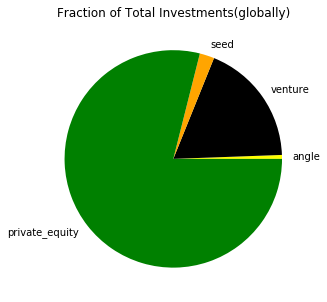

In [325]:
plt.figure(figsize=[10,5])
plt.title('Fraction of Total Investments(globally)')

labels = 'angle', 'venture', 'seed', 'private_equity'
colors = ['yellow', 'black', 'orange', 'green']

plt.pie(plot_df, labels=labels, colors=colors)
plt.show()

**1.b. Average amount of investment**

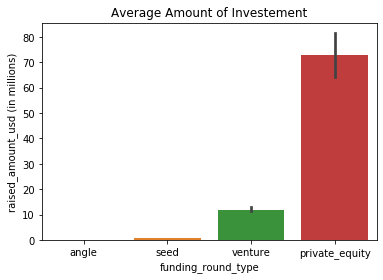

In [326]:
plt.title("Average Amount of Investement") 
sns.barplot(x=master_frame['funding_round_type'],y=master_frame['raised_amount_usd']/1000000,estimator=np.mean,order=["angle","seed","venture","private_equity"])
plt.ylabel("raised_amount_usd (in millions)")
plt.show()

**2. A plot showing the top 9 countries against the total amount of investments of funding type FT. This should make the top 3 countries (Country 1, Country 2, and Country 3) very clear.**

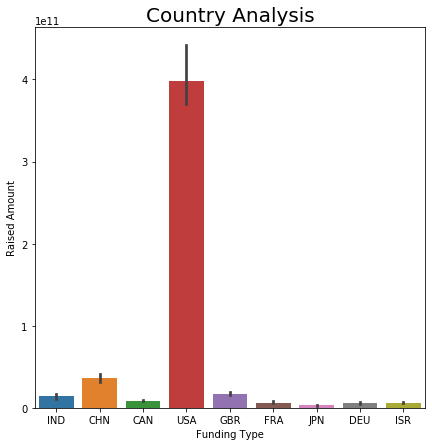

In [327]:
plt.figure(figsize=(7,7))
c=sns.barplot(x='country_code', y='raised_amount_usd', data=top9, estimator=np.sum)
c.set_title('Country Analysis',fontsize =20)
c.set(xlabel='Funding Type', ylabel='Raised Amount')
plt.show()

#usa, chn, gbr

**3. A plot showing the number of investments in the top 3 sectors of the top 3 countries on one chart (for the chosen investment type FT).**

In [328]:
D=D1[D1['main_sector'].isin(['Others','Social, Finance, Analytics, Advertising','Cleantech / Semiconductors'])]
D=D.append(D2[D2['main_sector'].isin(['Others','Social, Finance, Analytics, Advertising','Cleantech / Semiconductors'])], ignore_index=True)
D=D.append(D3[D3['main_sector'].isin(['Others','Social, Finance, Analytics, Advertising','News, Search and Messaging'])], ignore_index=True)

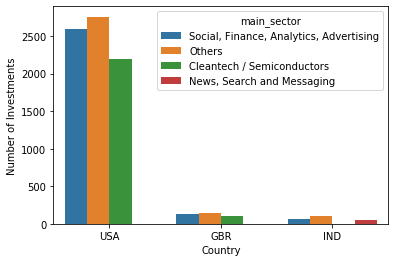

In [329]:
c.set_title('investment Analysis',fontsize =20)
c=sns.barplot(x='country_code', y='raised_amount_usd', hue="main_sector", data=D, estimator=lambda x: len(x))
c.set(xlabel='Country', ylabel='Number of Investments')
plt.show()